In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
XRay_Directory = './OperationsData/OpDept/Dataset'

In [7]:
os.listdir(XRay_Directory)

['0', '1', '2', '3']

In [8]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [9]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")


Found 428 images belonging to 4 classes.


In [10]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")


Found 104 images belonging to 4 classes.


In [11]:
train_images, train_labels = next(train_generator)


In [12]:
train_images.shape

(40, 256, 256, 3)

In [13]:
train_labels.shape

(40, 4)

In [14]:
train_labels

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]],

In [15]:
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

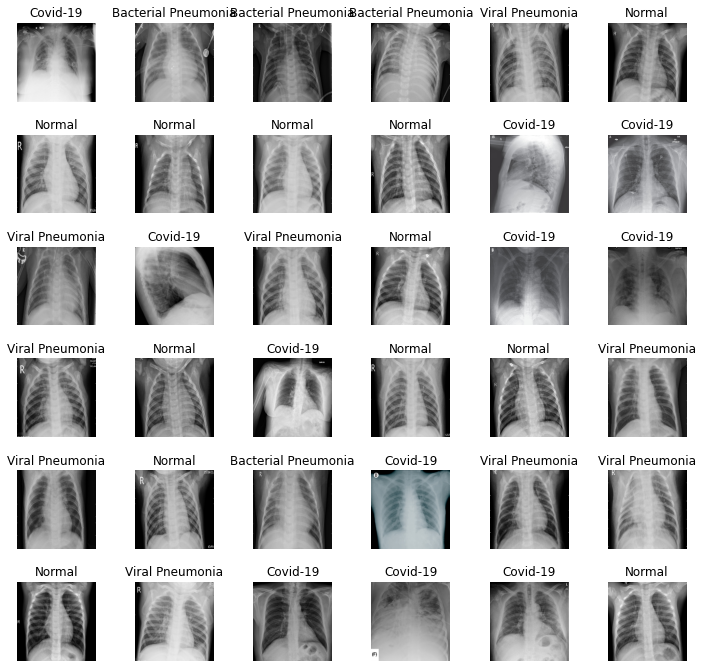

In [16]:
# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

In [17]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [18]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

In [20]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

C:\Users\abish\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [22]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="./OperationsData/OpDept/weights.hdf5", verbose=1, save_best_only=True)

In [23]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [24]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

C:\Users\abish\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
107/107 [==============================] - 126s 1s/step - loss: 0.8674 - accuracy: 0.6893 - val_loss: 7.4573 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 7.45731, saving model to ./OperationsData/OpDept\weights.hdf5


C:\Users\abish\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
107/107 [==============================] - 112s 1s/step - loss: 0.4168 - accuracy: 0.8668 - val_loss: 18.7080 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 7.45731
Epoch 3/10
107/107 [==============================] - 116s 1s/step - loss: 0.2519 - accuracy: 0.9182 - val_loss: 30.5951 - val_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 7.45731
Epoch 4/10
107/107 [==============================] - 121s 1s/step - loss: 0.2170 - accuracy: 0.9533 - val_loss: 12.3370 - val_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 7.45731
Epoch 5/10
107/107 [==============================] - 128s 1s/step - loss: 0.2328 - accuracy: 0.9416 - val_loss: 6.2053 - val_accuracy: 0.2500

Epoch 00005: val_loss improved from 7.45731 to 6.20534, saving model to ./OperationsData/OpDept\weights.hdf5
Epoch 6/10
107/107 [==============================] - 121s 1s/step - loss: 0.1341 - accuracy: 0.9766 - val_loss: 6.6091 - val_accuracy: 0.3077

Epoch 00006: va

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

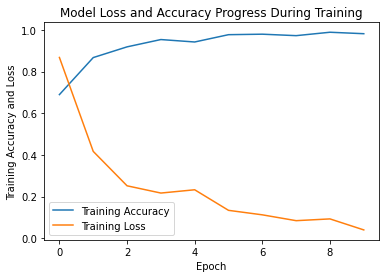

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

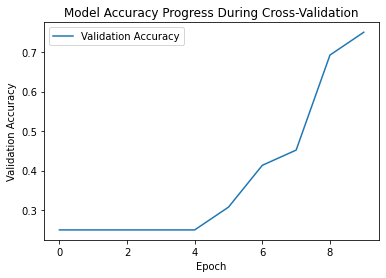

In [27]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [28]:
test_directory = './OperationsData/OpDept/Test'

In [29]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


C:\Users\abish\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


10/10 [==============================] - 3s 4ms/step - loss: 3.6692 - accuracy: 0.6750
Accuracy Test : 0.675000011920929


In [30]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [31]:
len(original)

40

In [32]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.65


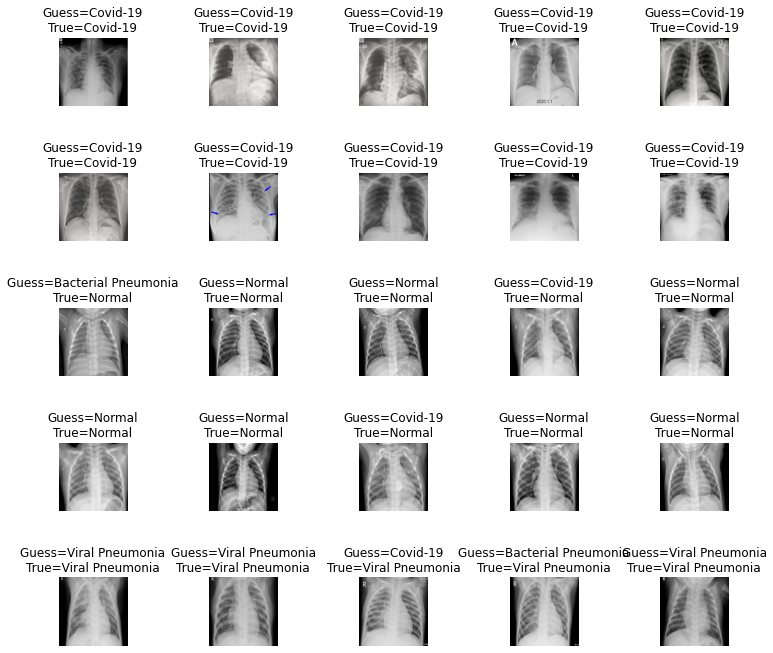

In [33]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [34]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.78      0.70      0.74        10
           2       1.00      0.30      0.46        10
           3       0.67      0.60      0.63        10

    accuracy                           0.65        40
   macro avg       0.74      0.65      0.63        40
weighted avg       0.74      0.65      0.63        40



Text(0.5, 1.0, 'Confusion_matrix')

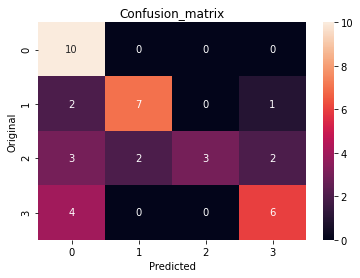

In [35]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')